In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests


In [2]:
def simulate_ar1_data(n, m, phi=0.7, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    data = np.zeros((n, m))
    var0 = sigma**2 / (1-phi**2)
    for row in range(n):
        X0 = rng.normal(0, np.sqrt(var0))
        seq = np.zeros(m)
        seq[0] = X0
        for i in range(1, m):
            eps = rng.normal(0, sigma)
            seq[i] = phi*seq[i-1] + eps
        data[row,:] = seq
    return data

def simulate_cs_data(n, m, sigma_alpha=1.0, sigma_eps=1.0, seed=42):
    rng = np.random.default_rng(seed)
    data = np.zeros((n, m))
    for row in range(n):
        alpha = rng.normal(0, np.sqrt(sigma_alpha))
        eps = rng.normal(0, np.sqrt(sigma_eps), size=m)
        data[row, :] = alpha + eps
    return data

def simulate_block_data(n, m, block_size=4, rho=0.7, seed=42):
    rng = np.random.default_rng(seed)
    data = np.zeros((n, m))
    n_blocks = m // block_size
    remainder = m % block_size

    for row in range(n):
        X = np.zeros(m)
        idx = 0
        for b in range(n_blocks):
            start = b*block_size
            end   = start + block_size
            alpha_b = rng.normal(0, np.sqrt(rho))
            eps_b   = rng.normal(0, np.sqrt(1-rho), size=block_size)
            X[start:end] = alpha_b + eps_b
            idx = end
        if remainder>0:
            alpha_r = rng.normal(0, np.sqrt(rho))
            eps_r   = rng.normal(0, np.sqrt(1-rho), size=remainder)
            X[idx: idx+remainder] = alpha_r + eps_r
        
        data[row,:] = X
    return data


In [6]:
def simulate_labels_logistic(X, pi1=0.2, delta=0.5, noise_sd=4.0, seed=0):
    rng = np.random.default_rng(seed)
    n, m = X.shape
    m1 = int(np.round(pi1*m))
    idx_true = rng.choice(m, size=m1, replace=False)
    true_mask = np.zeros(m, dtype=bool)
    true_mask[idx_true] = True

    beta = np.zeros(m)
    beta[true_mask] = delta

    # Add additional noise to the linear predictor
    noise = rng.normal(0, noise_sd, size=n)
    logits = X @ beta + noise
    p = 1 / (1 + np.exp(-logits))
    y = rng.binomial(1, p)
    return y, true_mask, beta


def single_feature_pvals(X, y):
    n, m = X.shape
    pvals = np.ones(m)
    for j in range(m):
        Xj = sm.add_constant(X[:,[j]])  # shape (n,2)
        try:
            res = sm.Logit(y, Xj).fit(disp=0)
            pvals[j] = res.pvalues[1]  # index 1 for the feature
        except:
            pvals[j] = 1.0
    return pvals

def storey_qvalue(pvals, lamb=0.5):
    m = len(pvals)
    pi0 = min(1.0, np.mean(pvals>lamb)/(1-lamb))
    ranks = np.argsort(np.argsort(pvals)) + 1
    qvals = pi0 * m * pvals / ranks
    # ensure monotonic
    sorted_q = np.sort(qvals)
    for i in range(m-2, -1, -1):
        sorted_q[i] = min(sorted_q[i], sorted_q[i+1])
    out = np.empty(m)
    out[np.argsort(pvals)] = sorted_q
    return out

def compute_fdr_power(pvals, true_mask, alpha, method='fdr_bh'):
    if method in ['fdr_bh','fdr_by','bonferroni','holm']:
        rej, _, _, _ = multipletests(pvals, alpha=alpha, method=method)
    elif method=='storey':
        qvals = storey_qvalue(pvals, lamb=0.5)
        rej = (qvals < alpha)
    else:
        raise ValueError("Unknown method: " + method)
    
    tp = np.sum(rej & true_mask)
    fp = np.sum(rej & (~true_mask))
    fn = np.sum((~rej) & true_mask)
    
    if (tp+fp) > 0:
        fdr = fp/(tp+fp)
    else:
        fdr = 0.0
    if (tp+fn) > 0:
        power = tp/(tp+fn)
    else:
        power = 0.0
    return fdr, power


In [7]:
#####################
# [2A] Experiment Setup
#####################

n, m = 100, 20
pi1, delta = 0.3, 0.5
n_sim = 50
alpha_fixed = 0.05  # fixed threshold
corr_params = [0.0, 0.3, 0.5, 0.7, 0.9]
data_types = ['AR','CS','Block']
methods = ['fdr_bh','fdr_by','storey']

def max_consecutive_false_positives(rej, true_mask):
    idx_fp = np.where(rej & (~true_mask))[0]
    if len(idx_fp)<2:
        return len(idx_fp)
    diffs = np.diff(idx_fp)
    max_streak = 1
    cur_streak = 1
    for d in diffs:
        if d==1:
            cur_streak += 1
            if cur_streak>max_streak:
                max_streak=cur_streak
        else:
            cur_streak=1
    return max_streak

#####################
# [2B] Run the experiment at a fixed alpha
#####################

res_fixedalpha = []
for data_type in data_types:
    for cp in corr_params:
        summary = {mtd: {'FDR':0,'Power':0,'MaxFP':0,'NReject':0} for mtd in methods}
        
        for sim in range(n_sim):
            seed_val = 1000*sim + int(cp*100)
            # generate X
            if data_type=='AR':
                X = simulate_ar1_data(n, m, phi=cp, sigma=1.0, seed=seed_val)
            elif data_type=='CS':
                X = simulate_cs_data(n, m, sigma_alpha=cp+0.5, sigma_eps=1.0, seed=seed_val)
            elif data_type=='Block':
                X = simulate_block_data(n, m, block_size=5, rho=cp, seed=seed_val)
            else:
                raise ValueError("Unknown data_type")
            
            y, true_mask, _ = simulate_labels_logistic(X, pi1=pi1, delta=delta, seed=999+sim)
            
            pvals = single_feature_pvals(X,y)
        
            for mtd in methods:
                fdr_val, power_val = compute_fdr_power(pvals, true_mask, alpha_fixed, mtd)

                if mtd in ['fdr_bh','fdr_by','storey']:
                    if mtd in ['fdr_bh','fdr_by','holm','bonferroni']:
                        rej, _, _, _ = multipletests(pvals, alpha=alpha_fixed, method=mtd)
                    elif mtd=='storey':
                        qv = storey_qvalue(pvals, lamb=0.5)
                        rej = (qv<alpha_fixed)
                    
                    mcfp = max_consecutive_false_positives(rej, true_mask)
                    n_rej = np.sum(rej)
                summary[mtd]['FDR']   += fdr_val
                summary[mtd]['Power'] += power_val
                summary[mtd]['MaxFP'] += mcfp
                summary[mtd]['NReject'] += n_rej
        
        for mtd in methods:
            for key in summary[mtd]:
                summary[mtd][key] /= n_sim
        
        for mtd in methods:
            res_fixedalpha.append({
                'DataType': data_type,
                'CorrParam': cp,
                'Method': mtd,
                'FDR': summary[mtd]['FDR'],
                'TPR': summary[mtd]['Power'],
                'MaxConsecutiveFP': summary[mtd]['MaxFP'],
                'NumReject': summary[mtd]['NReject'],
                'Alpha': alpha_fixed
            })

df_fixedalpha = pd.DataFrame(res_fixedalpha)
df_fixedalpha.head(10)


,DataType,CorrParam,Method,FDR,TPR,MaxConsecutiveFP,NumReject,Alpha
0,AR,0.0,fdr_bh,0.020000,0.013333,0.02,0.10,0.05
1,AR,0.0,fdr_by,0.000000,0.006667,0.00,0.04,0.05
2,AR,0.0,storey,0.020000,0.016667,0.02,0.12,0.05
3,AR,0.3,fdr_bh,0.020000,0.033333,0.02,0.22,0.05
4,AR,0.3,fdr_by,0.000000,0.003333,0.00,0.02,0.05
5,AR,0.3,storey,0.026667,0.050000,0.04,0.34,0.05
6,AR,0.5,fdr_bh,0.121333,0.080000,0.26,0.82,0.05
7,AR,0.5,fdr_by,0.030000,0.020000,0.04,0.16,0.05
8,AR,0.5,storey,0.185595,0.133333,0.48,1.60,0.05
9,AR,0.7,fdr_bh,0.328343,0.416667,1.26,5.02,0.05


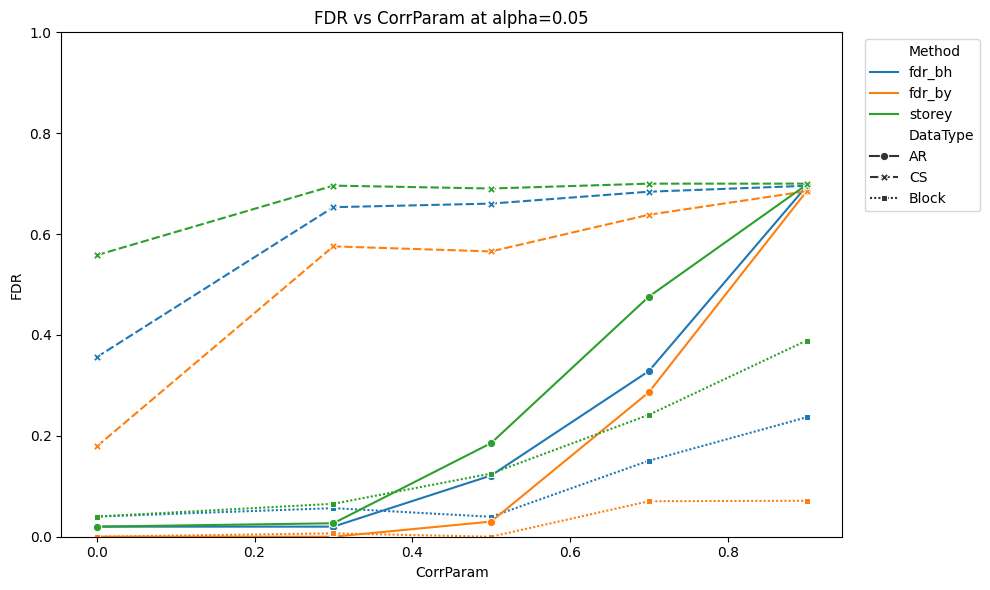

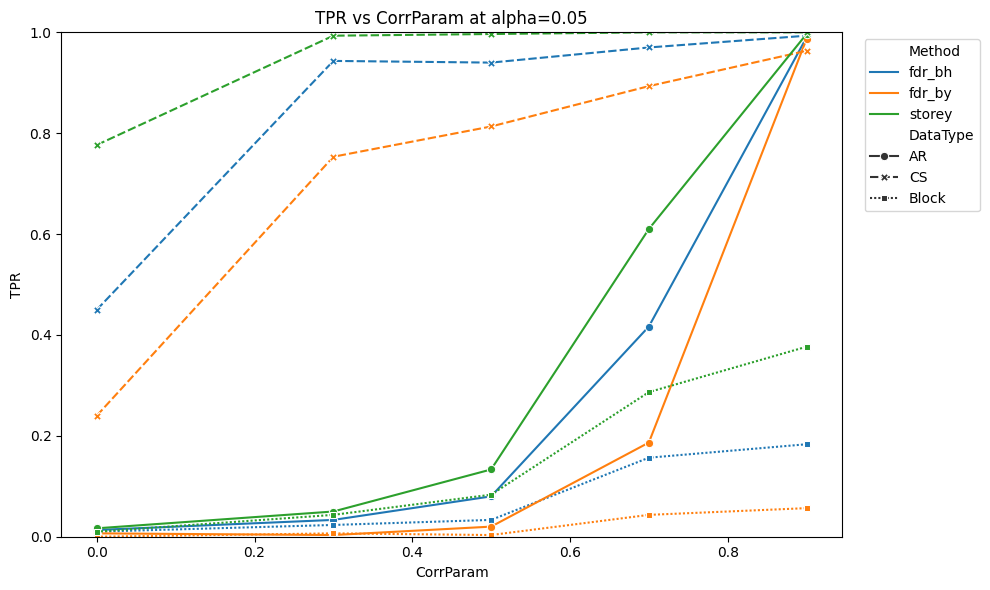

In [7]:
#####################
# Plot FDR, Power, MaxFP vs CorrParam
#####################

plt.figure(figsize=(10,6))
sns.lineplot(data=df_fixedalpha, x="CorrParam", y="FDR", hue="Method", style="DataType", markers=True)
plt.title(f"FDR vs CorrParam at alpha={alpha_fixed}")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=df_fixedalpha, x="CorrParam", y="TPR", hue="Method", style="DataType", markers=True)
plt.title(f"TPR vs CorrParam at alpha={alpha_fixed}")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()




In [8]:
#####################
# [3A] Setup for alpha-grid experiment
#####################

alpha_grid = np.linspace(0,0.2, 101)
data_types = ['AR','CS','Block']
corr_params = [0.0, 0.3, 0.5, 0.7]
fdr_methods = ['fdr_bh','fdr_by','storey']
n_sim = 50
n, m = 300, 20
pi1, delta = 0.3, 2.0

exp_records = []

for data_type in data_types:
    for cp in corr_params:
        pvals_all = []
        true_mask_all = []
        for sim in range(n_sim):
            seed_val = 1000*sim + int(cp*100)
            if data_type=='AR':
                X = simulate_ar1_data(n, m, phi=cp, sigma=1.0, seed=seed_val)
            elif data_type=='CS':
                X = simulate_cs_data(n, m, sigma_alpha=cp+0.5, sigma_eps=1.0, seed=seed_val)
            elif data_type=='Block':
                X = simulate_block_data(n, m, block_size=5, rho=cp, seed=seed_val)
            
            y, true_mask, _ = simulate_labels_logistic(X, pi1=pi1, delta=delta, seed=999+sim)
            pvals = single_feature_pvals(X, y)
            pvals_all.append(pvals)
            true_mask_all.append(true_mask)
        
        pvals_arr = np.vstack(pvals_all)         
        masks_arr = np.vstack(true_mask_all)    

        for alpha_th in alpha_grid:
            for mtd in fdr_methods:
                sum_fdr, sum_power = 0, 0
                for sim in range(n_sim):
                    fdr_val, power_val = compute_fdr_power(
                        pvals_arr[sim,:], masks_arr[sim,:],
                        alpha_th, method=mtd
                    )
                    sum_fdr += fdr_val
                    sum_power += power_val
                avg_fdr = sum_fdr/n_sim
                avg_power = sum_power/n_sim
                exp_records.append({
                    'DataType': data_type,
                    'CorrParam': cp,
                    'Alpha': alpha_th,
                    'Method': mtd,
                    'FDR': avg_fdr,
                    'Power': avg_power
                })

df_alphagrid = pd.DataFrame(exp_records)
df_alphagrid.head(10)


,DataType,CorrParam,Alpha,Method,FDR,Power
0,AR,0.0,0.000,fdr_bh,0.0,0.000000
1,AR,0.0,0.000,fdr_by,0.0,0.000000
2,AR,0.0,0.000,storey,0.0,0.000000
3,AR,0.0,0.002,fdr_bh,0.0,0.760000
4,AR,0.0,0.002,fdr_by,0.0,0.590000
5,AR,0.0,0.002,storey,0.0,0.783333
6,AR,0.0,0.004,fdr_bh,0.0,0.820000
7,AR,0.0,0.004,fdr_by,0.0,0.680000
8,AR,0.0,0.004,storey,0.0,0.840000
9,AR,0.0,0.006,fdr_bh,0.0,0.856667


In [9]:
import warnings
warnings.filterwarnings("ignore")

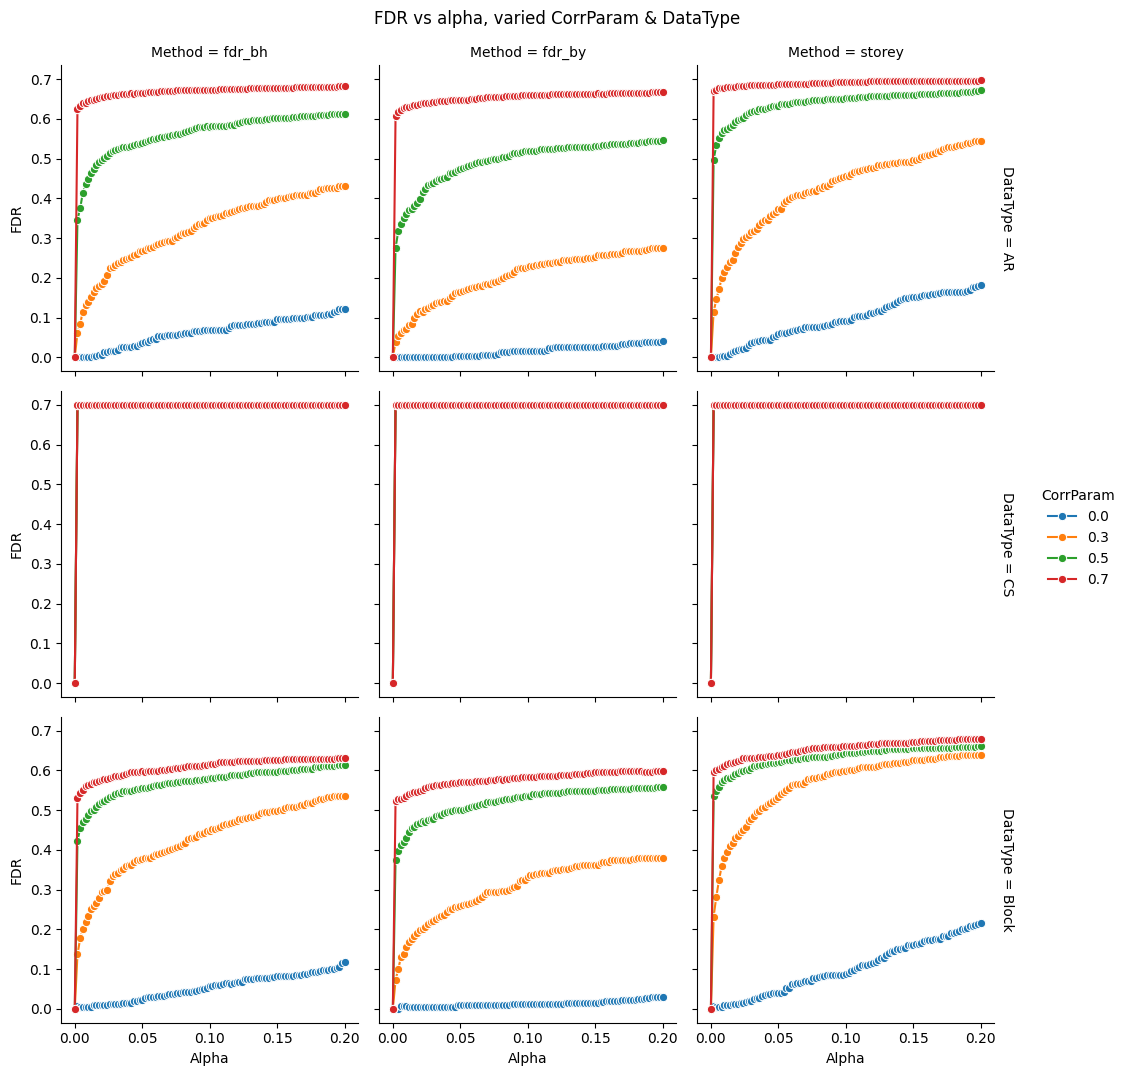

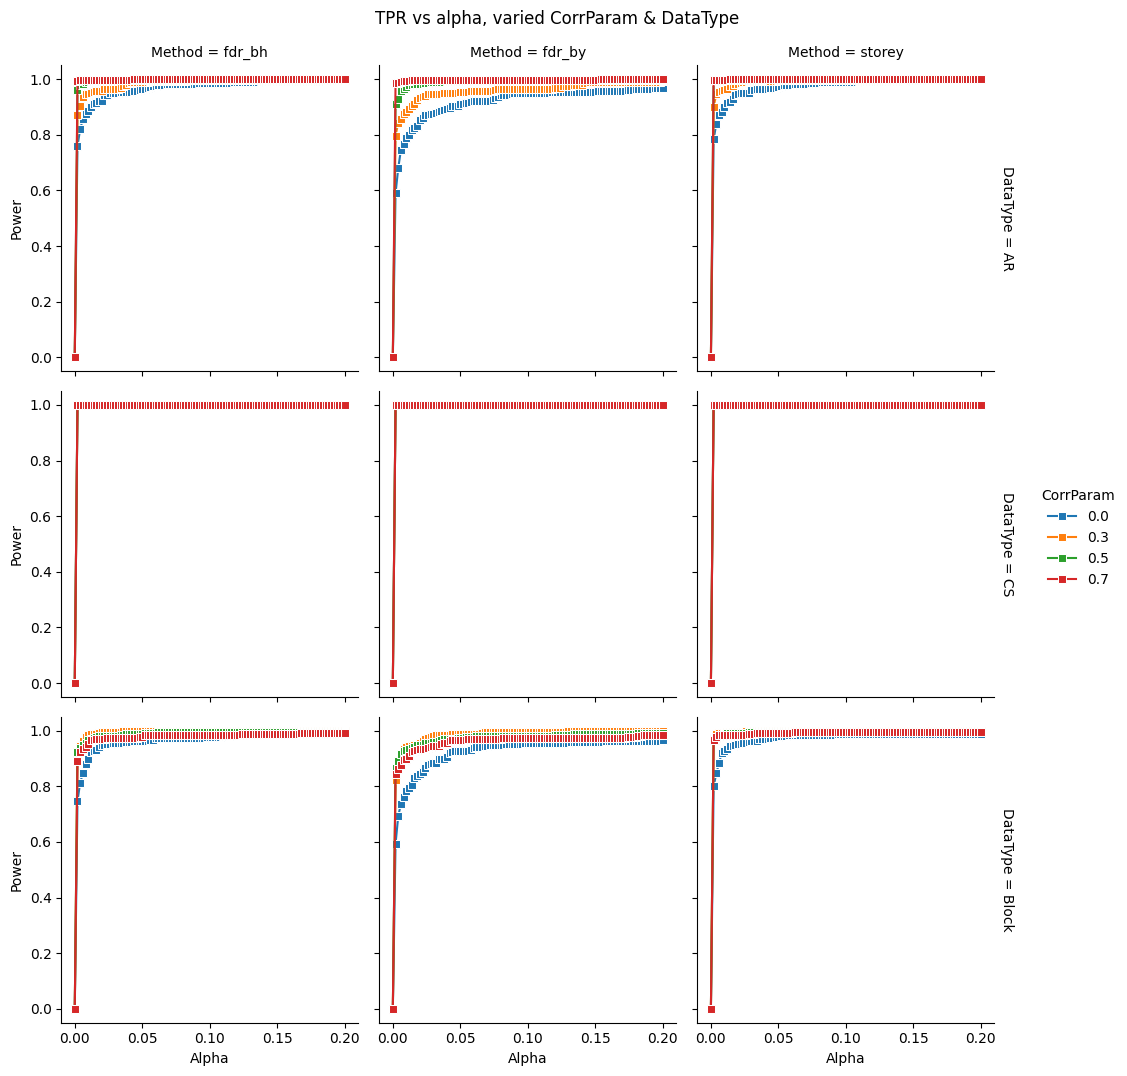

In [10]:
g = sns.FacetGrid(df_alphagrid, row="DataType", col="Method", hue="CorrParam",
                  margin_titles=
                  True, height=3.5)
g.map(sns.lineplot, "Alpha", "FDR", marker="o")
g.add_legend()
g.fig.suptitle("FDR vs alpha, varied CorrParam & DataType", y=1.02)
plt.show()

g2 = sns.FacetGrid(df_alphagrid, row="DataType", col="Method", hue="CorrParam",
                   margin_titles=True, height=3.5)
g2.map(sns.lineplot, "Alpha", "Power", marker="s")
g2.add_legend()
g2.fig.suptitle("TPR vs alpha, varied CorrParam & DataType", y=1.02)
plt.show()


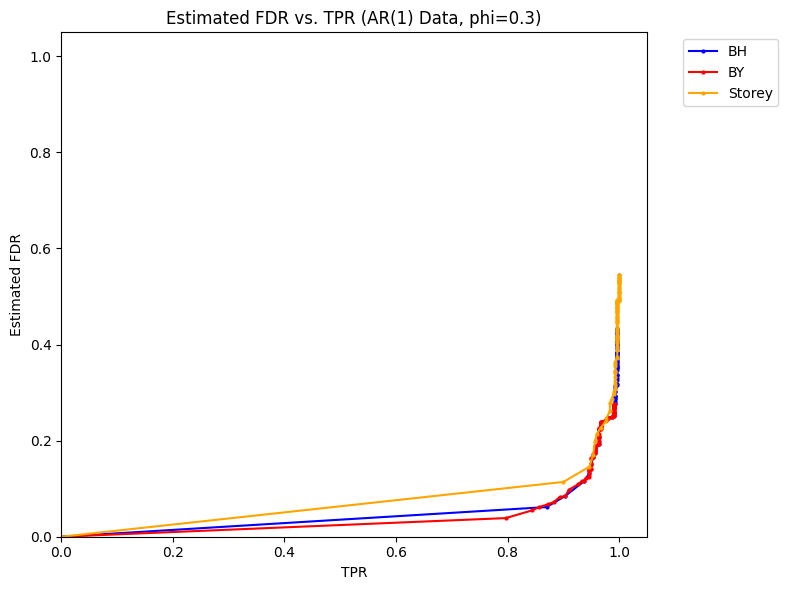

In [11]:
phi_test = 0.3


subset_bh = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_bh')
].copy()

subset_by = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_by')
].copy()

subset_storey = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'storey')
].copy()

subset_bh.sort_values(by="Alpha", inplace=True)
subset_by.sort_values(by="Alpha", inplace=True)
subset_storey.sort_values(by="Alpha", inplace=True)

plt.figure(figsize=(8,6))
plt.plot(subset_bh["Power"], subset_bh["FDR"], '-o', color='blue', markersize=2, label="BH")
plt.plot(subset_by["Power"], subset_by["FDR"], '-o', color='red', markersize=2, label="BY")
plt.plot(subset_storey["Power"], subset_storey["FDR"], '-o', color='orange', markersize=2, label="Storey")

plt.xlabel("TPR")
plt.ylabel("Estimated FDR")
plt.title(f"Estimated FDR vs. TPR (AR(1) Data, phi={phi_test})")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


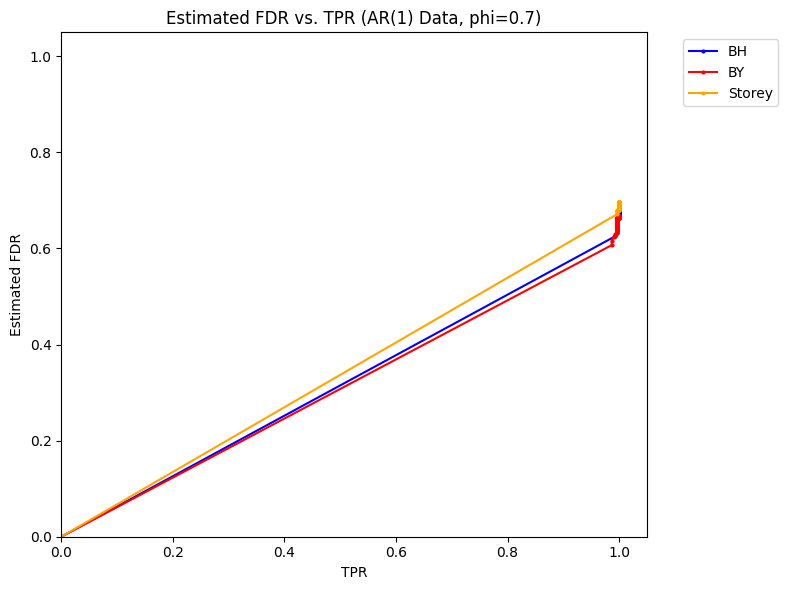

In [12]:
phi_test = 0.7

subset_bh = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_bh')
].copy()

subset_by = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_by')
].copy()

subset_storey = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'storey')
].copy()

subset_bh.sort_values(by="Alpha", inplace=True)
subset_by.sort_values(by="Alpha", inplace=True)
subset_storey.sort_values(by="Alpha", inplace=True)

plt.figure(figsize=(8,6))
plt.plot(subset_bh["Power"], subset_bh["FDR"], '-o', color='blue', markersize=2, label="BH")
plt.plot(subset_by["Power"], subset_by["FDR"], '-o', color='red', markersize=2, label="BY")
plt.plot(subset_storey["Power"], subset_storey["FDR"], '-o', color='orange', markersize=2, label="Storey")

plt.xlabel("TPR")
plt.ylabel("Estimated FDR")
plt.title(f"Estimated FDR vs. TPR (AR(1) Data, phi={phi_test})")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


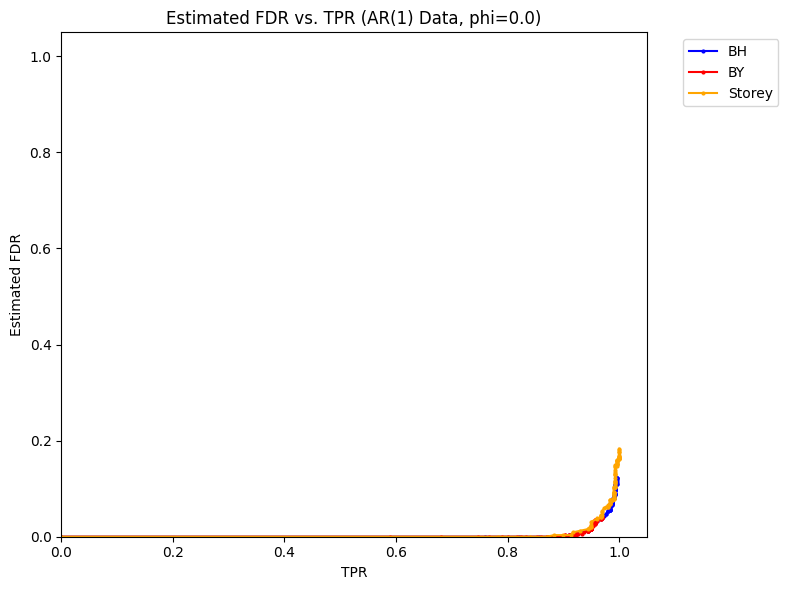

In [13]:
phi_test = 0.0

subset_bh = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_bh')
].copy()

subset_by = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_by')
].copy()

subset_storey = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'storey')
].copy()

subset_bh.sort_values(by="Alpha", inplace=True)
subset_by.sort_values(by="Alpha", inplace=True)
subset_storey.sort_values(by="Alpha", inplace=True)

plt.figure(figsize=(8,6))
plt.plot(subset_bh["Power"], subset_bh["FDR"], '-o', color='blue', markersize=2, label="BH")
plt.plot(subset_by["Power"], subset_by["FDR"], '-o', color='red', markersize=2, label="BY")
plt.plot(subset_storey["Power"], subset_storey["FDR"], '-o', color='orange', markersize=2, label="Storey")

plt.xlabel("TPR")
plt.ylabel("Estimated FDR")
plt.title(f"Estimated FDR vs. TPR (AR(1) Data, phi={phi_test})")
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


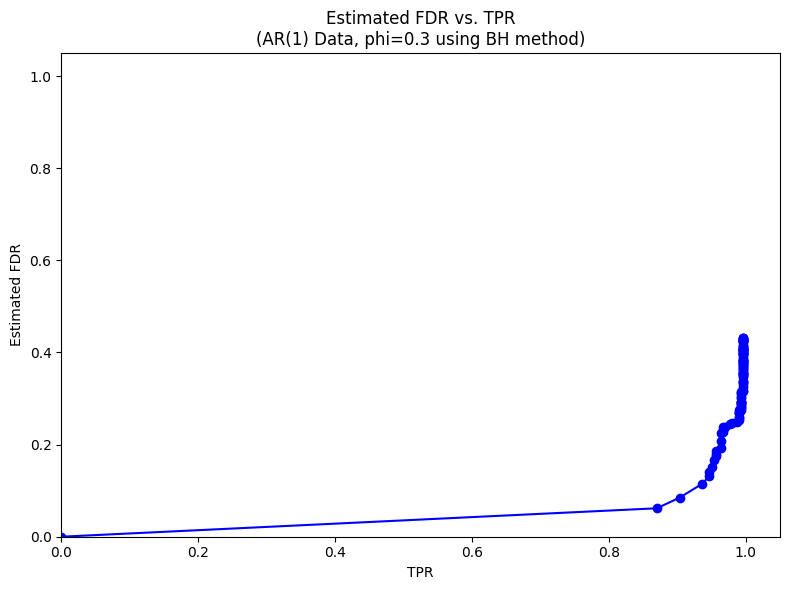

In [14]:
phi_test = 0.3
subset = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_bh')
]

plt.figure(figsize=(8,6))

plt.plot(subset["Power"],subset["FDR"],  '-o', color='blue')
plt.ylabel("Estimated FDR")
plt.xlabel("TPR")
plt.title(f"Estimated FDR vs. TPR\n(AR(1) Data, phi={phi_test} using BH method)")

    
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()


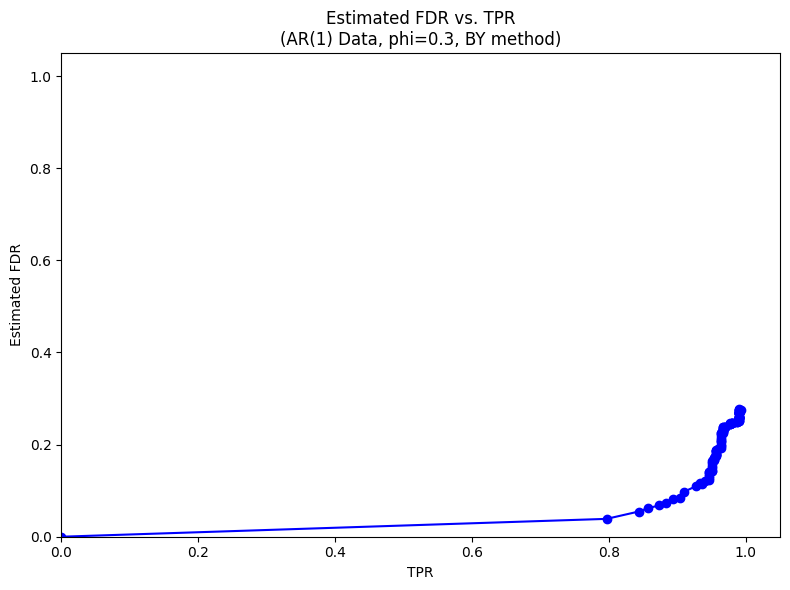

In [15]:
subset = df_alphagrid[
    (df_alphagrid['DataType'] == 'AR') &
    (df_alphagrid['CorrParam'] == phi_test) &
    (df_alphagrid['Method'] == 'fdr_by')
].copy()

subset.sort_values(by="Alpha", inplace=True)

plt.figure(figsize=(8,6))


plt.plot(subset["Power"],subset["FDR"],  '-o', color='blue')


plt.ylabel("Estimated FDR")
plt.xlabel("TPR")
plt.title(f"Estimated FDR vs. TPR\n(AR(1) Data, phi={phi_test}, BY method)")
plt.ylim(0, 1.05)
plt.xlim(0, 1.05)



plt.tight_layout()
plt.show()


=== AR1 with parameter 0 ===

=== AR1 with parameter 0.3 ===

=== AR1 with parameter 0.6 ===

=== AR1 with parameter 0.8 ===


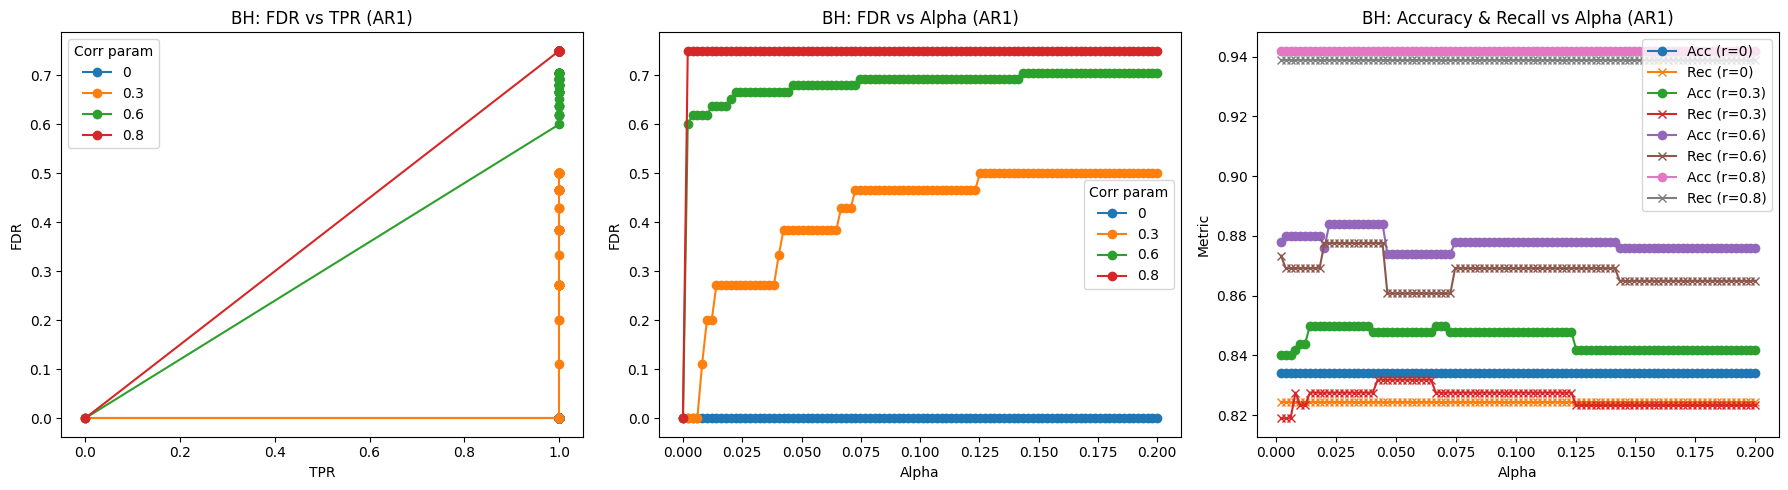

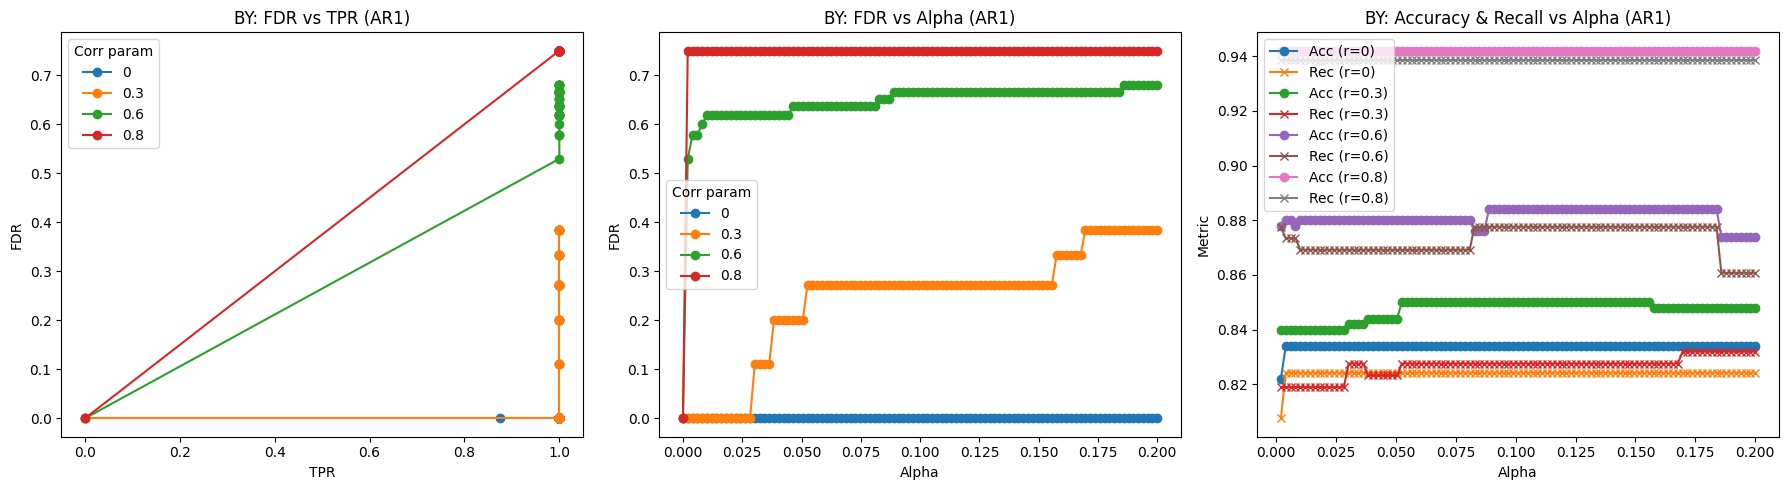

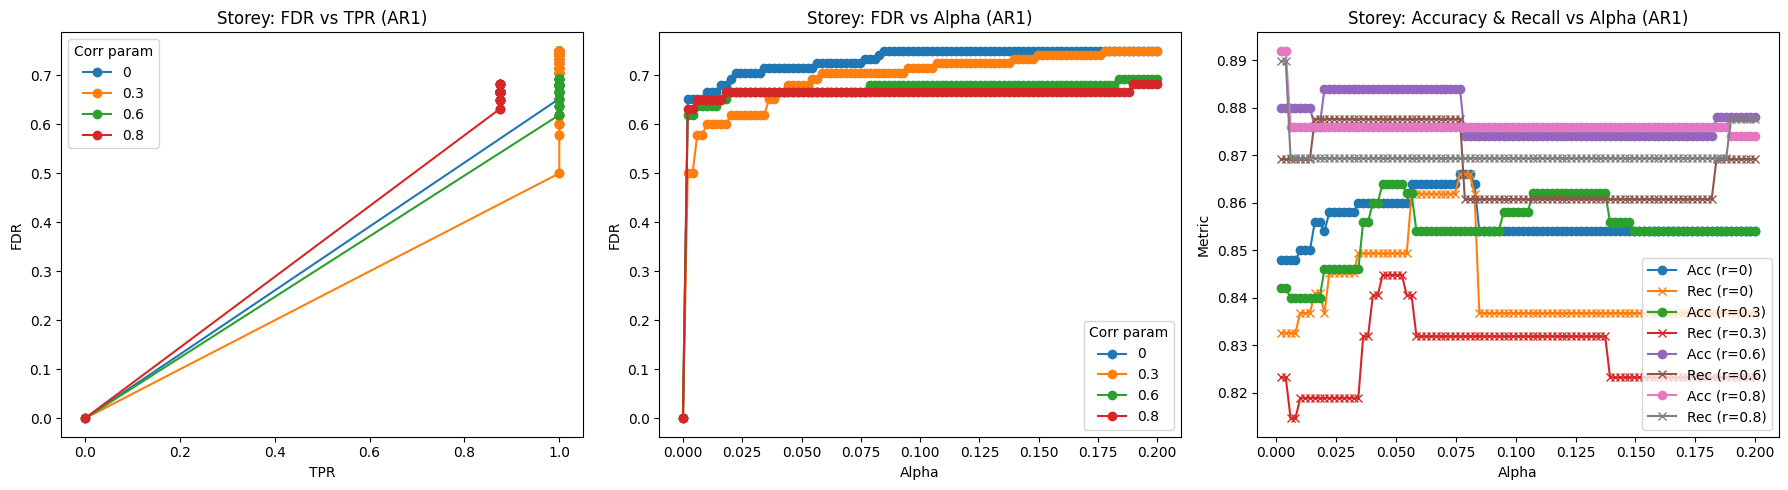

In [13]:
from scipy import stats
from sklearn.metrics import accuracy_score, recall_score

def simulate_ar1_logistic(n_samples, n_features, phi, n_true, seed=42):
    rng = np.random.default_rng(seed)

    X = np.zeros((n_samples, n_features))
    var0 = 1.0 / (1 - phi**2) 
    for i in range(n_samples):
        X0 = rng.normal(0, np.sqrt(var0))
        seq = np.zeros(n_features)
        seq[0] = X0
        for j in range(1, n_features):
            seq[j] = phi * seq[j-1] + rng.normal(0, 1.0)
        X[i, :] = seq

    true_mask = np.zeros(n_features, dtype=bool)
    true_idx = rng.choice(n_features, n_true, replace=False)
    true_mask[true_idx] = True
    true_beta = np.zeros(n_features)
    true_beta[true_mask] = rng.uniform(0.5, 1.5, n_true)
    
    lin_pred = np.dot(X, true_beta)
    def sigmoid(z): return 1/(1+np.exp(-z))
    p = sigmoid(lin_pred)
    y = rng.binomial(1, p)
    
    return X, y, true_mask, true_beta


def univariate_logistic_screen(X, y, top_k=None):
    n_samples, n_features = X.shape
    zscores = np.zeros(n_features)
    pvals = np.zeros(n_features)
    for j in range(n_features):
        X_j = sm.add_constant(X[:, j])
        model_j = sm.Logit(y, X_j).fit(disp=False)
        zscores[j] = model_j.tvalues[1]  
        pvals[j] = model_j.pvalues[1]    
    all_idx = np.arange(n_features)
    if top_k is not None and top_k < n_features:
        sort_idx = np.argsort(pvals)
        selected_idx = sort_idx[:top_k]
    else:
        selected_idx = all_idx
    return selected_idx, zscores, pvals


def estimate_empirical_null(zscores, central_frac=0.2):
    m = len(zscores)
    sort_absz = np.sort(np.abs(zscores))
    cutoff_idx = int(m * central_frac)
    cutoff_idx = max(cutoff_idx, 1)
    cutoff_val = sort_absz[cutoff_idx]
    mask_center = (np.abs(zscores) <= cutoff_val)
    mu0 = np.mean(zscores[mask_center])
    sigma0 = np.std(zscores[mask_center], ddof=1)
    return mu0, sigma0

def storey_qvalues(zscores, central_frac=0.2):


    mu0, sigma0 = estimate_empirical_null(zscores, central_frac=central_frac)
    z_adj = (zscores - mu0) / sigma0
    pvals_emp = 2 * (1 - stats.norm.cdf(np.abs(z_adj)))
    
    m = len(pvals_emp)
    sort_idx = np.argsort(pvals_emp)
    pvals_sorted = pvals_emp[sort_idx]
    p0_est, _ = estimate_empirical_null(zscores, central_frac=central_frac)
    qvals_sorted = p0_est * m * pvals_sorted / np.arange(1, m+1)
    qvals_sorted = np.minimum.accumulate(qvals_sorted[::-1])[::-1]
    qvals = np.empty_like(qvals_sorted)
    qvals[sort_idx] = qvals_sorted
    return qvals, p0_est


def evaluate_FDR_methods(X, y, true_mask, alpha_list, method='BH'):
    n_samples, n_features = X.shape
    _, zscores, pvals = univariate_logistic_screen(X, y, top_k=None)
    
    results = []
    for alpha in alpha_list:
        if method == 'BH':
            reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
        elif method == 'BY':
            reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_by')
        elif method == 'Storey':
            qvals, p0_est = storey_qvalues(zscores)
            reject = qvals < alpha
            pvals_corr = qvals  
        else:
            raise ValueError("Method must be one of 'BH', 'BY', 'Storey'")
        
        num_reject = np.sum(reject)
        TP = np.sum(reject & true_mask)
        FP = num_reject - TP
        FDR = FP / num_reject if num_reject > 0 else 0.0
        TPR = TP / np.sum(true_mask) if np.sum(true_mask) > 0 else 0.0
        
        if num_reject > 0:
            selected_idx = np.where(reject)[0]
            X_selected = sm.add_constant(X[:, selected_idx])
            model_sel = sm.Logit(y, X_selected).fit(disp=False)
            y_pred_prob = model_sel.predict(X_selected)
            y_pred = (y_pred_prob >= 0.5).astype(int)
            acc = accuracy_score(y, y_pred)
            TP_model = np.sum((y_pred == 1) & (y == 1))
            FN_model = np.sum((y_pred == 0) & (y == 1))
            rec = TP_model / (TP_model + FN_model) if (TP_model + FN_model) > 0 else 0.0
        else:
            acc = np.nan
            rec = np.nan
        
        results.append({
            'alpha': alpha,
            'FDR': FDR,
            'TPR': TPR,
            'Accuracy': acc,
            'Recall': rec,
            'num_reject': num_reject
        })
    return pd.DataFrame(results)

# ----------------------------------------
def run_simulation_and_plot(correlation_type='AR1', corr_params=[0, 0.3, 0.6, 0.8],
                            n_samples=500, n_features=32, n_true=8, alpha_list=np.linspace(0.01, 0.2, 20)):
    methods = ['BH', 'BY', 'Storey']
    all_results = {method: {} for method in methods}
    
    for cp in corr_params:
        if correlation_type == 'AR1':
            X, y, true_mask, true_beta = simulate_ar1_logistic(n_samples, n_features, phi=cp, n_true=n_true)
        elif correlation_type == 'CS':
            sigma_alpha = np.sqrt(cp) if cp>=0 else 0
            sigma_eps = np.sqrt(1 - cp) if cp<=1 else 1
            X = simulate_cs_data(n_samples, n_features, sigma_alpha=sigma_alpha, sigma_eps=sigma_eps, seed=42)
            rng = np.random.default_rng(42)
            true_mask = np.zeros(n_features, dtype=bool)
            true_idx = rng.choice(n_features, n_true, replace=False)
            true_mask[true_idx] = True
            true_beta = np.zeros(n_features)
            true_beta[true_mask] = rng.uniform(0.5,1.5, n_true)
            lin_pred = np.dot(X, true_beta)
            def sigmoid(z): return 1/(1+np.exp(-z))
            p = sigmoid(lin_pred)
            y = rng.binomial(1, p)
        elif correlation_type == 'Block':
            X = simulate_block_data(n_samples, n_features, block_size=4, rho=cp, seed=42)
            rng = np.random.default_rng(42)
            true_mask = np.zeros(n_features, dtype=bool)
            true_idx = rng.choice(n_features, n_true, replace=False)
            true_mask[true_idx] = True
            true_beta = np.zeros(n_features)
            true_beta[true_mask] = rng.uniform(0.5,1.5, n_true)
            lin_pred = np.dot(X, true_beta)
            def sigmoid(z): return 1/(1+np.exp(-z))
            p = sigmoid(lin_pred)
            y = rng.binomial(1, p)
        else:
            raise ValueError("Unknown correlation_type.")
        
        print(f"\n=== {correlation_type} with parameter {cp} ===")
        
        for method in methods:
            df = evaluate_FDR_methods(X, y, true_mask, alpha_list, method=method)
            all_results[method][cp] = df
    
    for method in methods:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        for cp in corr_params:
            df = all_results[method][cp]
            # a. FDR vs TPR
            axs[0].plot(df['TPR'], df['FDR'], marker='o', label=f"{cp}")
            # b. FDR vs alpha
            axs[1].plot(df['alpha'], df['FDR'], marker='o', label=f"{cp}")
            # c. Accuracy and Recall vs alpha
            axs[2].plot(df['alpha'], df['Accuracy'], marker='o', label=f"Acc (r={cp})")
            axs[2].plot(df['alpha'], df['Recall'], marker='x', label=f"Rec (r={cp})")
        
        axs[0].set_xlabel("TPR")
        axs[0].set_ylabel("FDR")
        axs[0].set_title(f"{method}: FDR vs TPR ({correlation_type})")
        axs[0].legend(title="Corr param")
        
        axs[1].set_xlabel("Alpha")
        axs[1].set_ylabel("FDR")
        axs[1].set_title(f"{method}: FDR vs Alpha ({correlation_type})")
        axs[1].legend(title="Corr param")
        
        axs[2].set_xlabel("Alpha")
        axs[2].set_ylabel("Metric")
        axs[2].set_title(f"{method}: Accuracy & Recall vs Alpha ({correlation_type})")
        axs[2].legend()
        
        plt.tight_layout()
        plt.show()
    
    return all_results


def simulate_cs_data(n, m, sigma_alpha=1.0, sigma_eps=1.0, seed=42):
    rng = np.random.default_rng(seed)
    data = np.zeros((n, m))
    for i in range(n):
        alpha = rng.normal(0, np.sqrt(sigma_alpha))
        eps = rng.normal(0, np.sqrt(sigma_eps), size=m)
        data[i, :] = alpha + eps
    return data

def simulate_block_data(n, m, block_size=4, rho=0.7, seed=42):
    rng = np.random.default_rng(seed)
    data = np.zeros((n, m))
    n_blocks = m // block_size
    remainder = m % block_size
    for i in range(n):
        X = np.zeros(m)
        idx = 0
        for b in range(n_blocks):
            start = b * block_size
            end   = start + block_size
            alpha_b = rng.normal(0, np.sqrt(rho))
            eps_b   = rng.normal(0, np.sqrt(1 - rho), size=block_size)
            X[start:end] = alpha_b + eps_b
            idx = end
        if remainder > 0:
            alpha_r = rng.normal(0, np.sqrt(rho))
            eps_r   = rng.normal(0, np.sqrt(1 - rho), size=remainder)
            X[idx: idx+remainder] = alpha_r + eps_r
        data[i, :] = X
    return data

def simulate_ar1_data(n, m, phi=0.7, sigma=1.0, seed=42):
    rng = np.random.default_rng(seed)
    data = np.zeros((n, m))
    var0 = sigma**2 / (1 - phi**2)
    for i in range(n):
        X0 = rng.normal(0, np.sqrt(var0))
        seq = np.zeros(m)
        seq[0] = X0
        for j in range(1, m):
            seq[j] = phi * seq[j-1] + rng.normal(0, sigma)
        data[i, :] = seq
    return data


all_results_AR1 = run_simulation_and_plot(correlation_type='AR1', corr_params=[0, 0.3, 0.6, 0.8],
                                          n_samples=500, n_features=32, n_true=8,
                                          alpha_list=np.linspace(0.0, 0.2, 100))



=== CS with parameter 0 ===

=== CS with parameter 0.3 ===

=== CS with parameter 0.6 ===

=== CS with parameter 0.8 ===


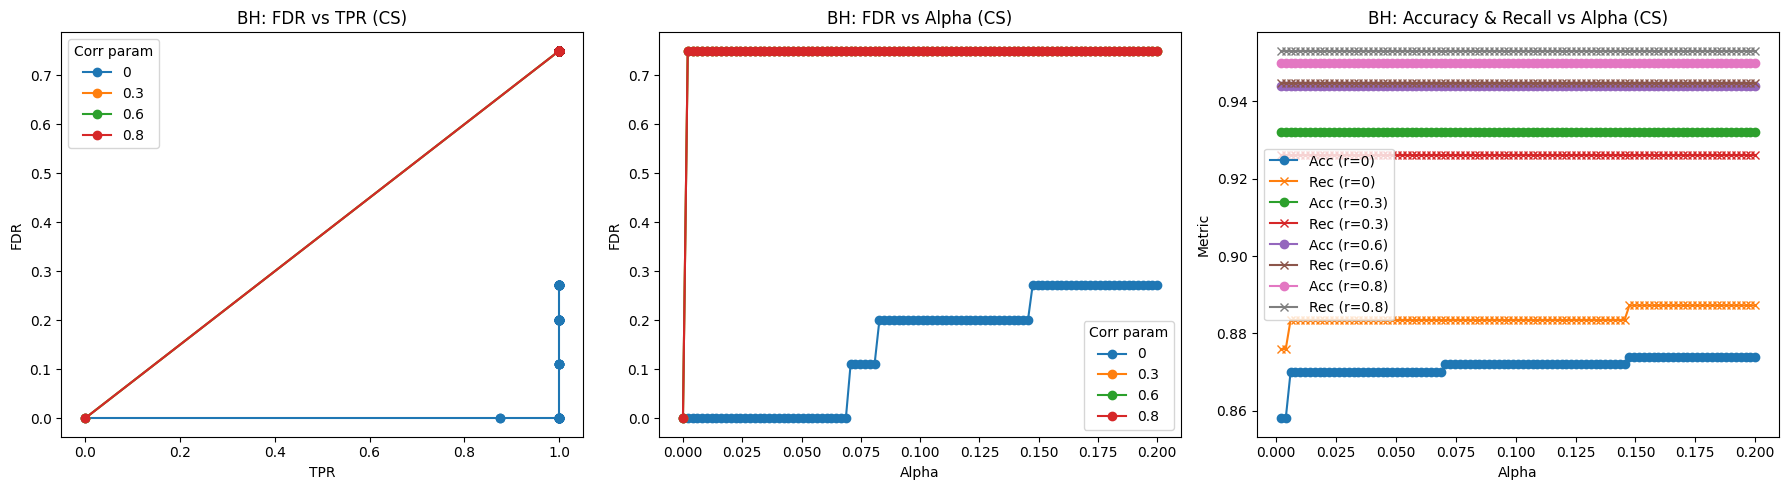

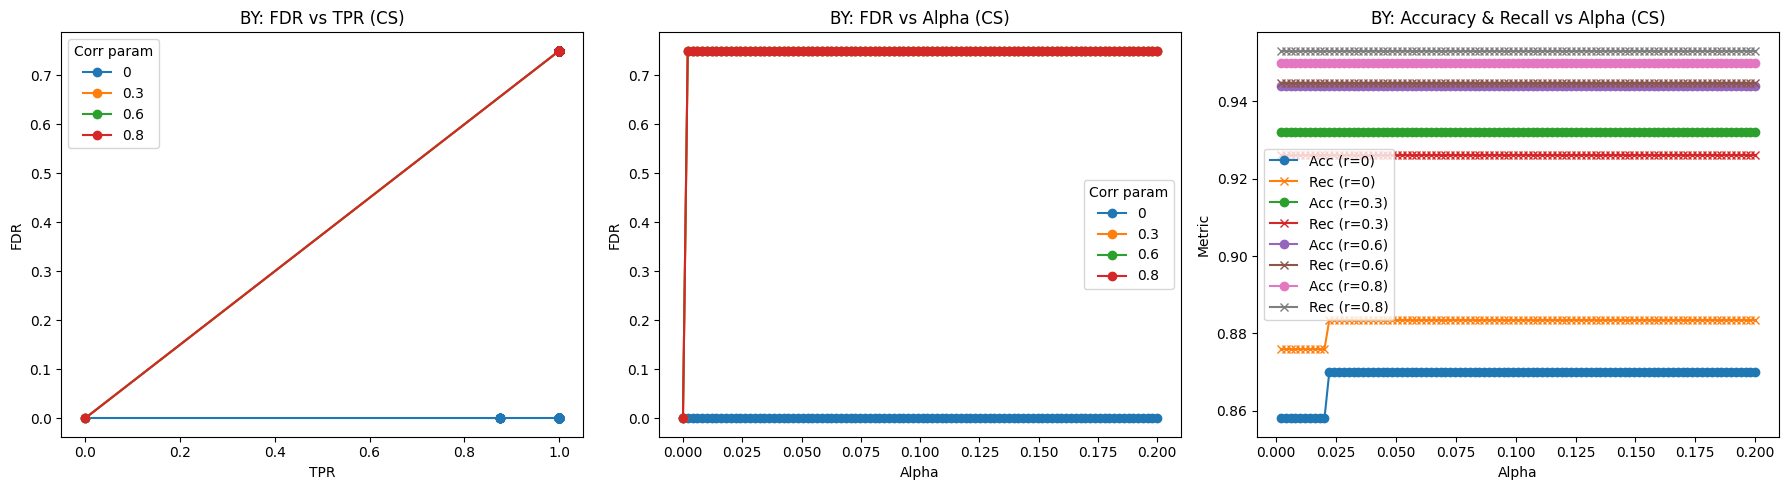

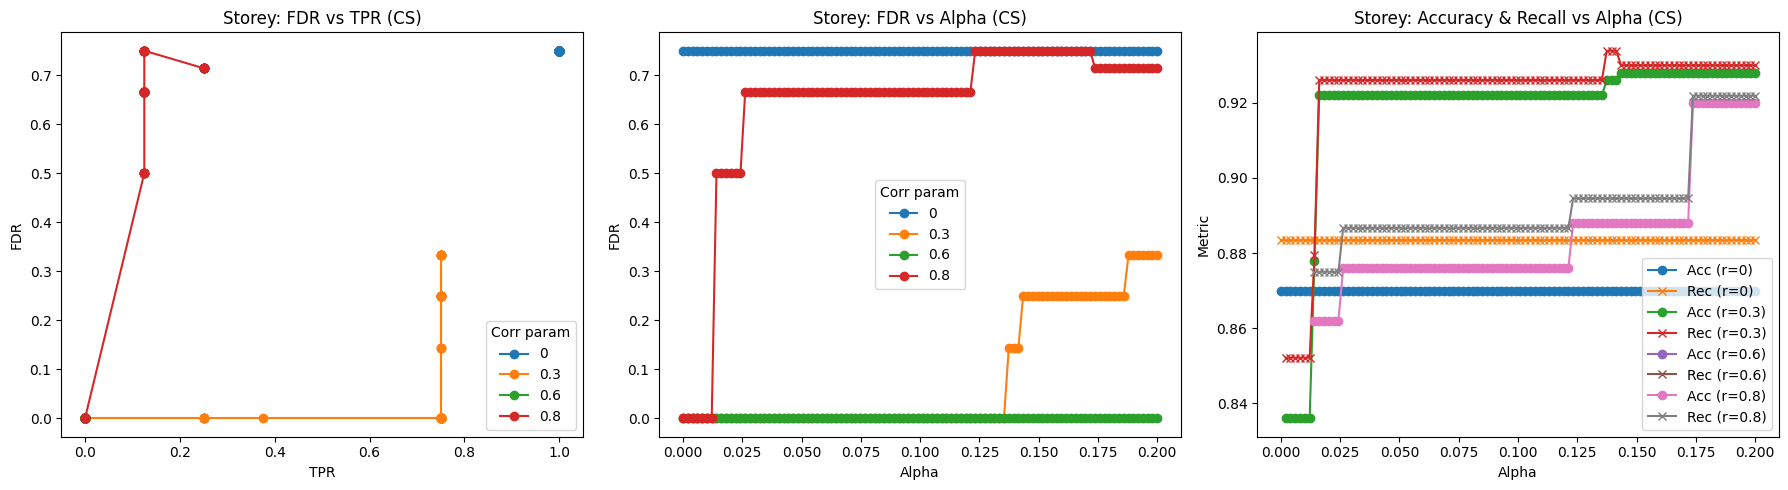

In [14]:
all_results_AR1 = run_simulation_and_plot(correlation_type='CS', corr_params=[0, 0.3, 0.6, 0.8],
                                          n_samples=500, n_features=32, n_true=8,
                                          alpha_list=np.linspace(0.0, 0.2, 100))



=== Block with parameter 0 ===

=== Block with parameter 0.3 ===

=== Block with parameter 0.6 ===

=== Block with parameter 0.8 ===


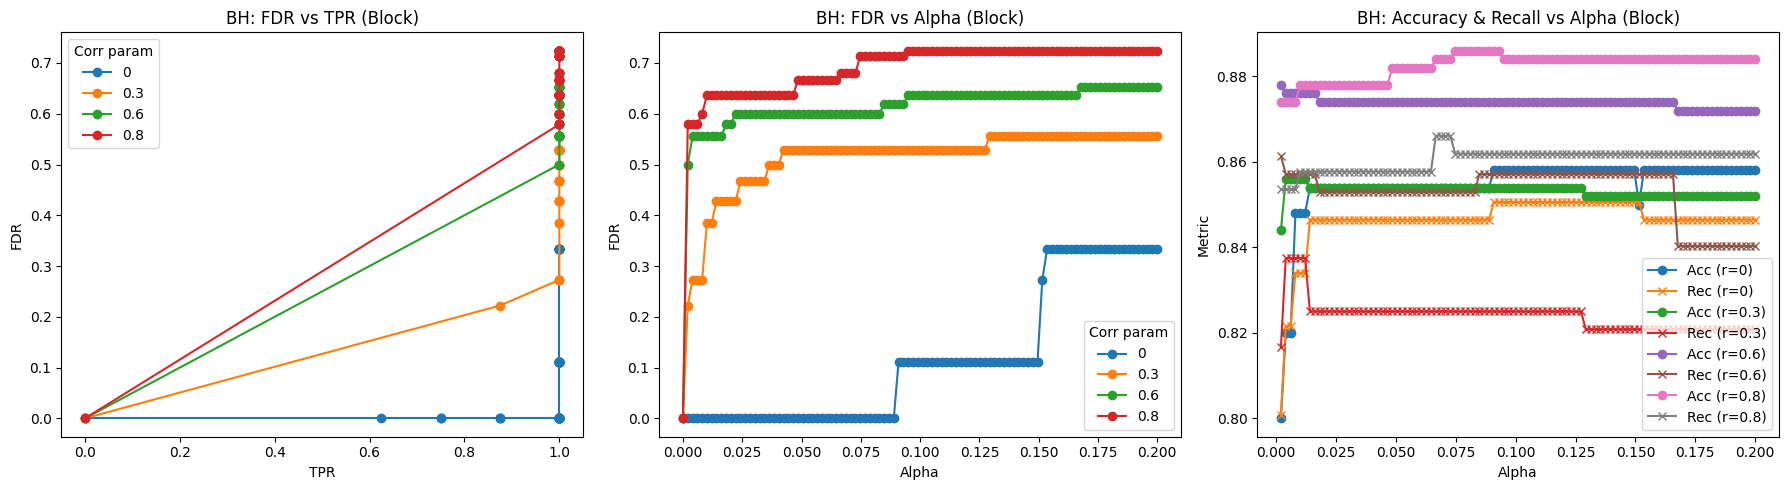

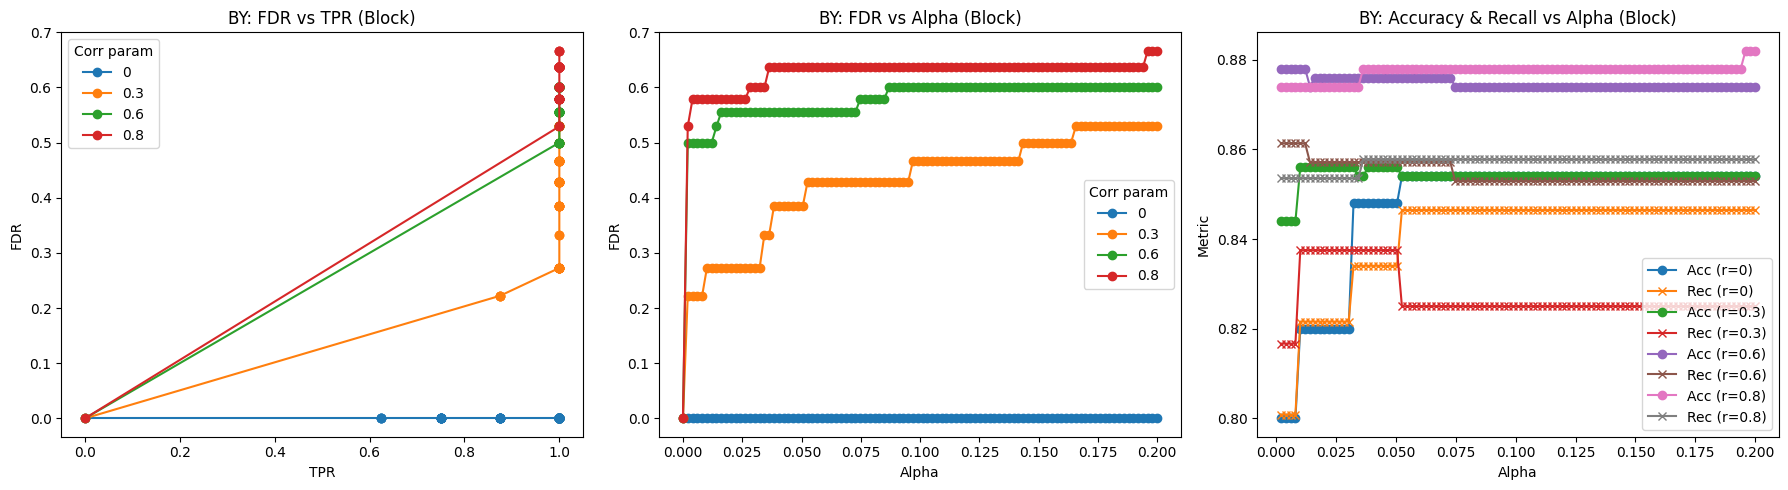

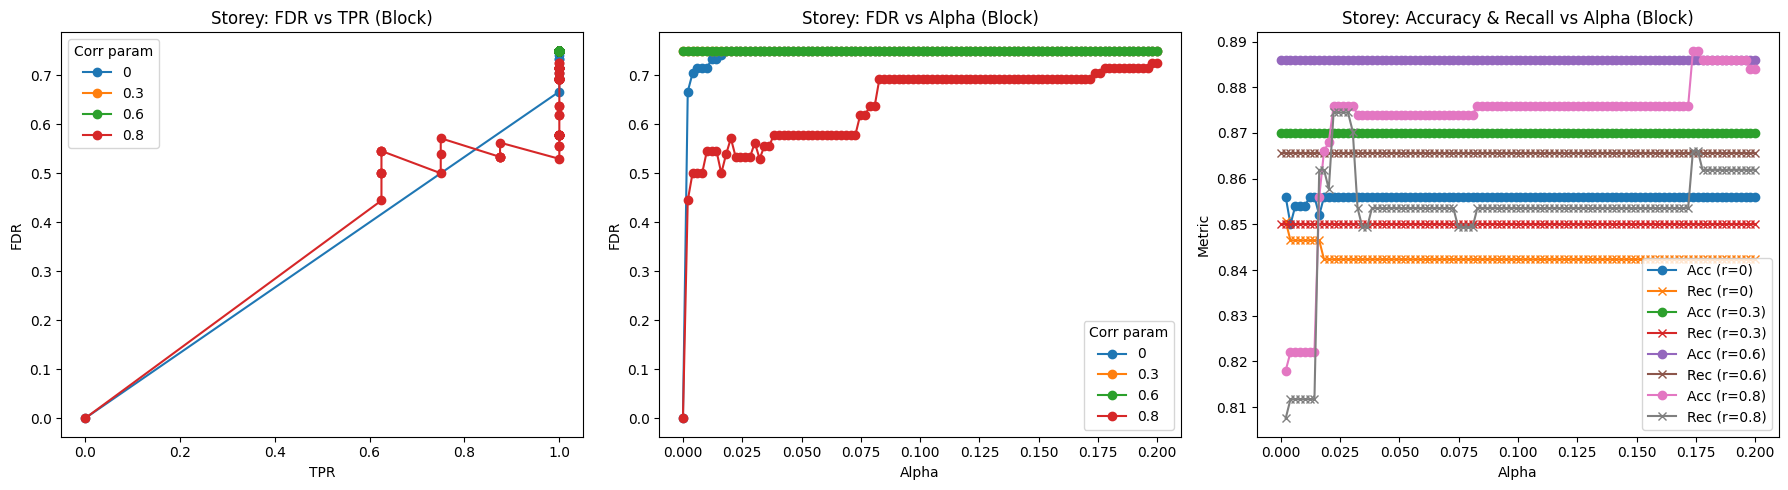

In [15]:
all_results_AR1 = run_simulation_and_plot(correlation_type='Block', corr_params=[0, 0.3, 0.6, 0.8],
                                          n_samples=500, n_features=32, n_true=8,
                                          alpha_list=np.linspace(0.0, 0.2, 100))


Running extended simulation for AR(1) structure...

=== AR1 with parameter 0 ===

=== AR1 with parameter 0.3 ===

=== AR1 with parameter 0.6 ===

=== AR1 with parameter 0.8 ===


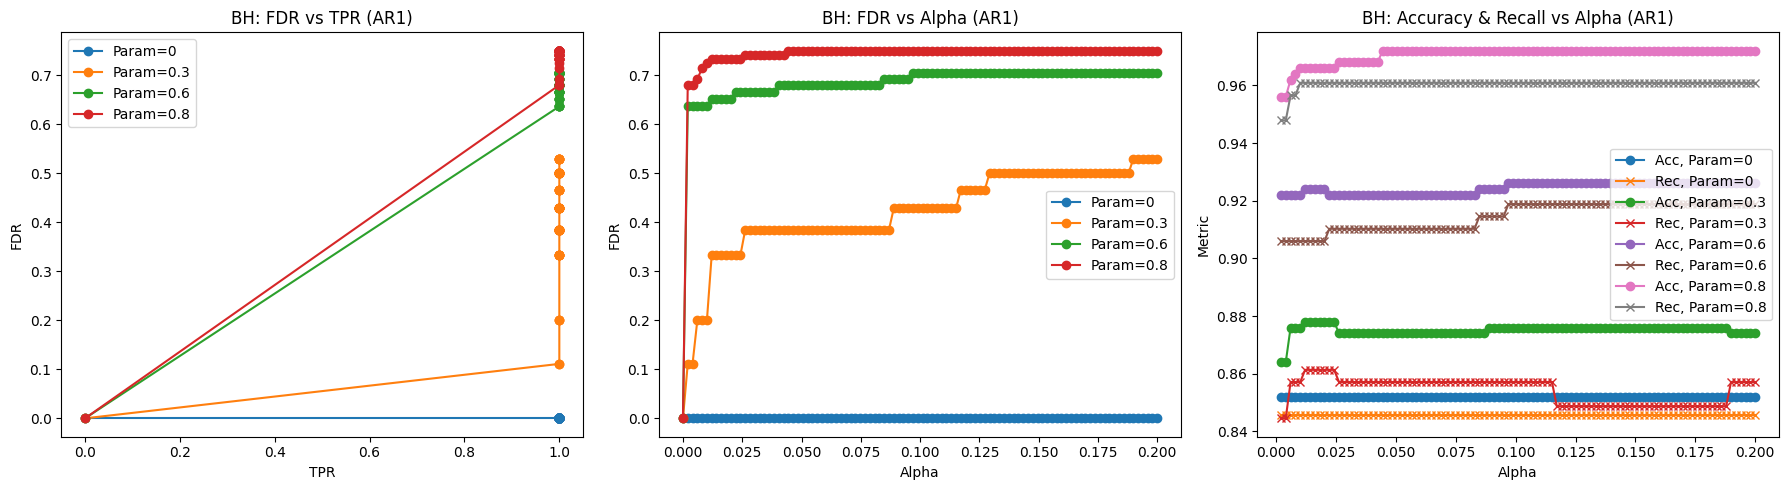

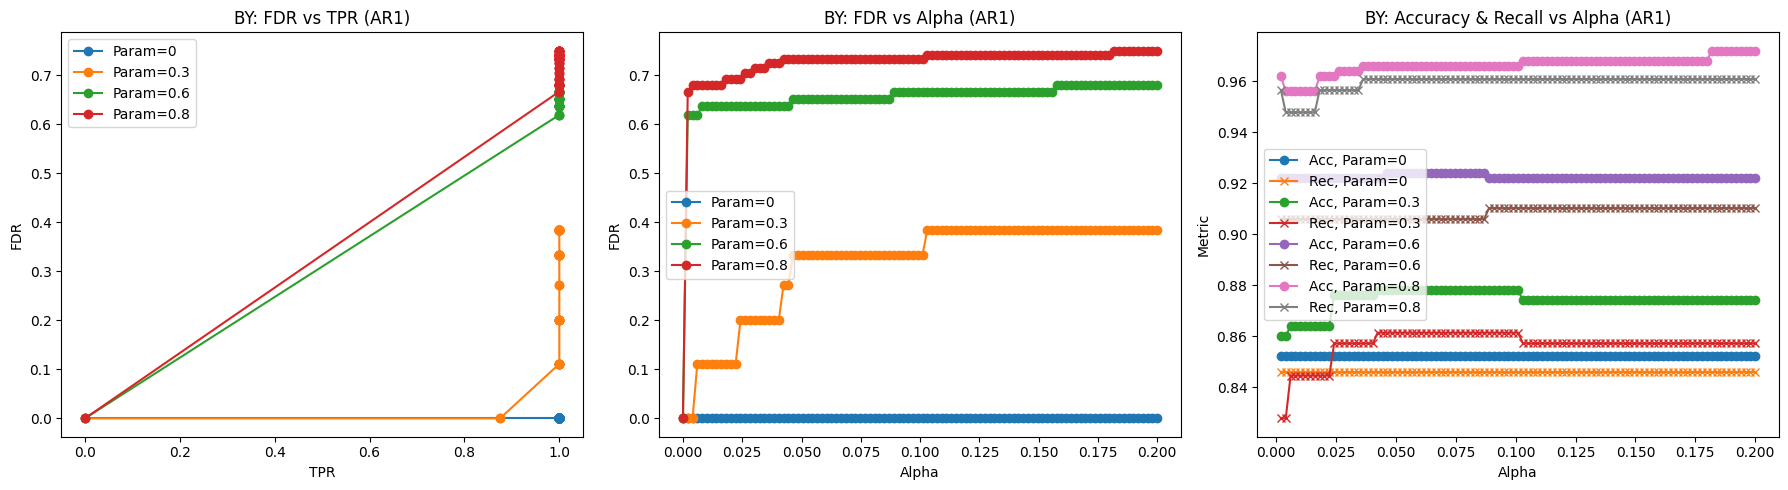

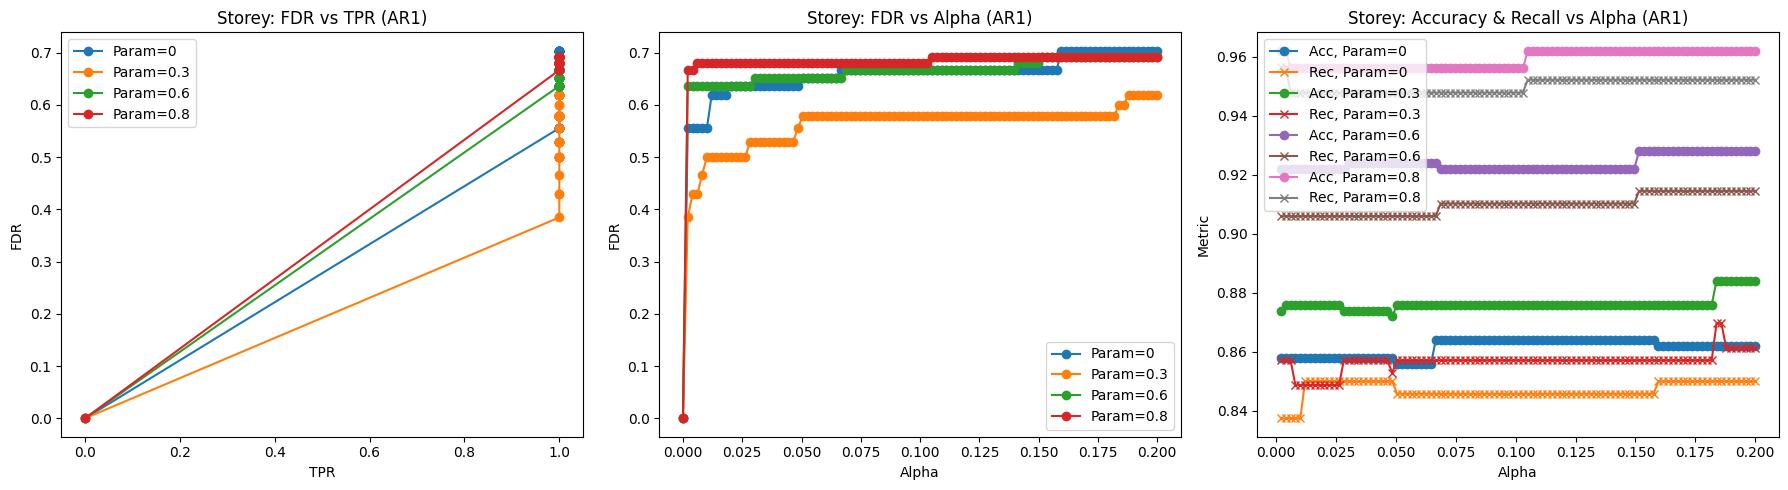

Running extended simulation for CS structure...

=== CS with parameter 0.1 ===

=== CS with parameter 0.3 ===

=== CS with parameter 0.5 ===

=== CS with parameter 0.7 ===


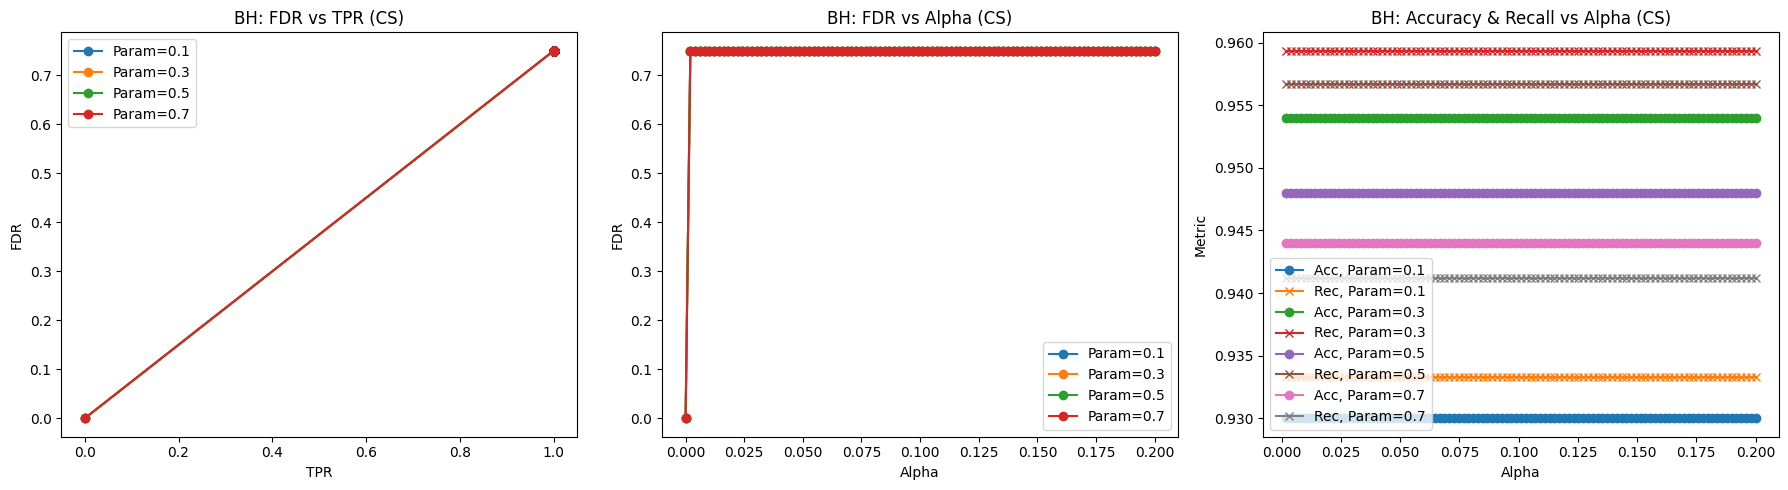

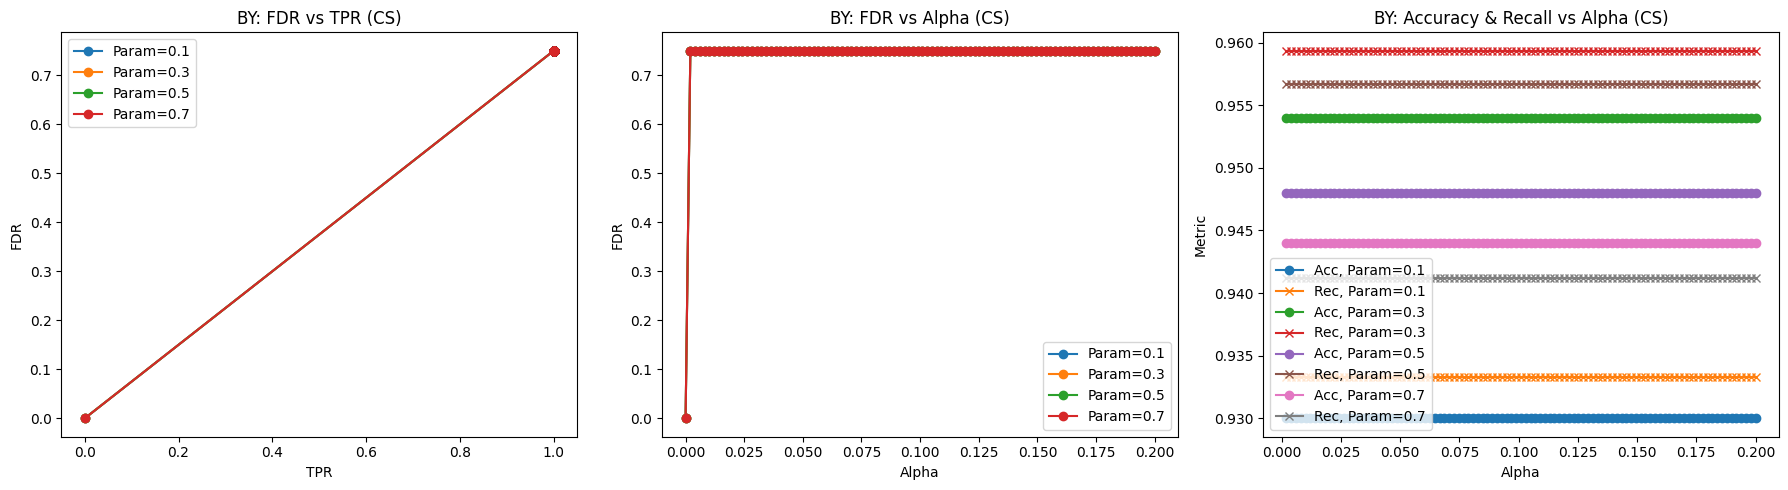

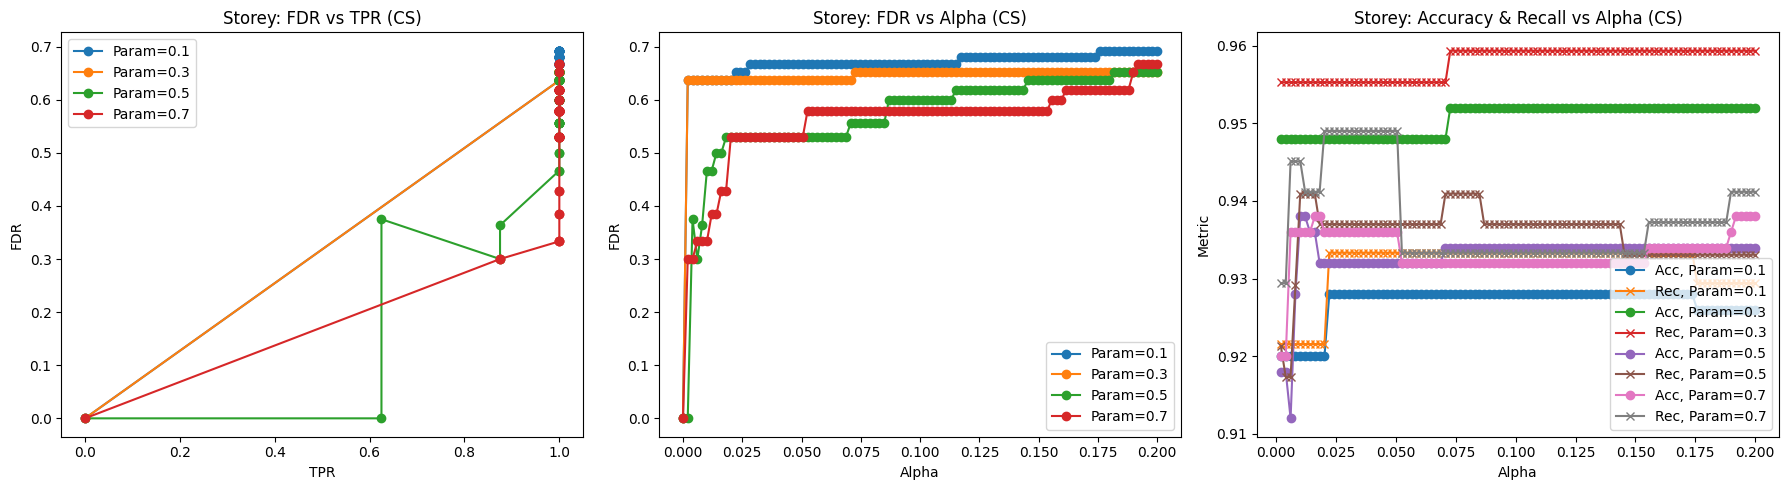

Running extended simulation for Block structure...

=== Block with parameter 0.1 ===

=== Block with parameter 0.3 ===

=== Block with parameter 0.5 ===

=== Block with parameter 0.7 ===


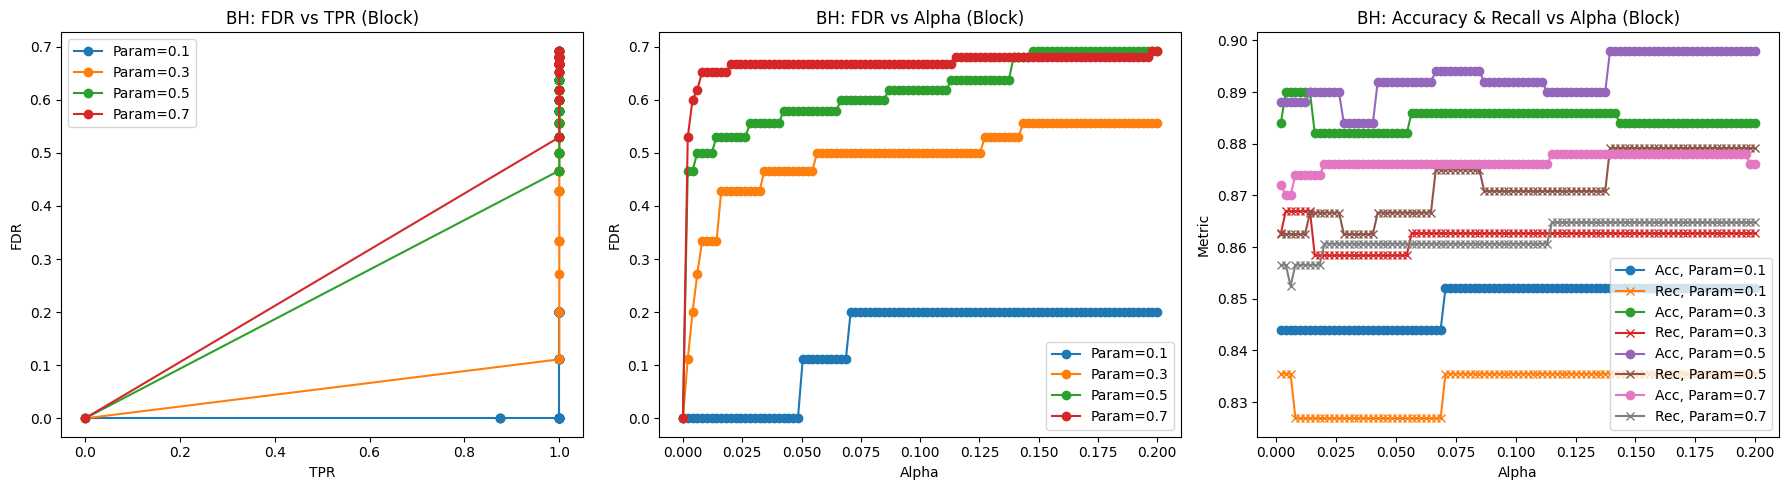

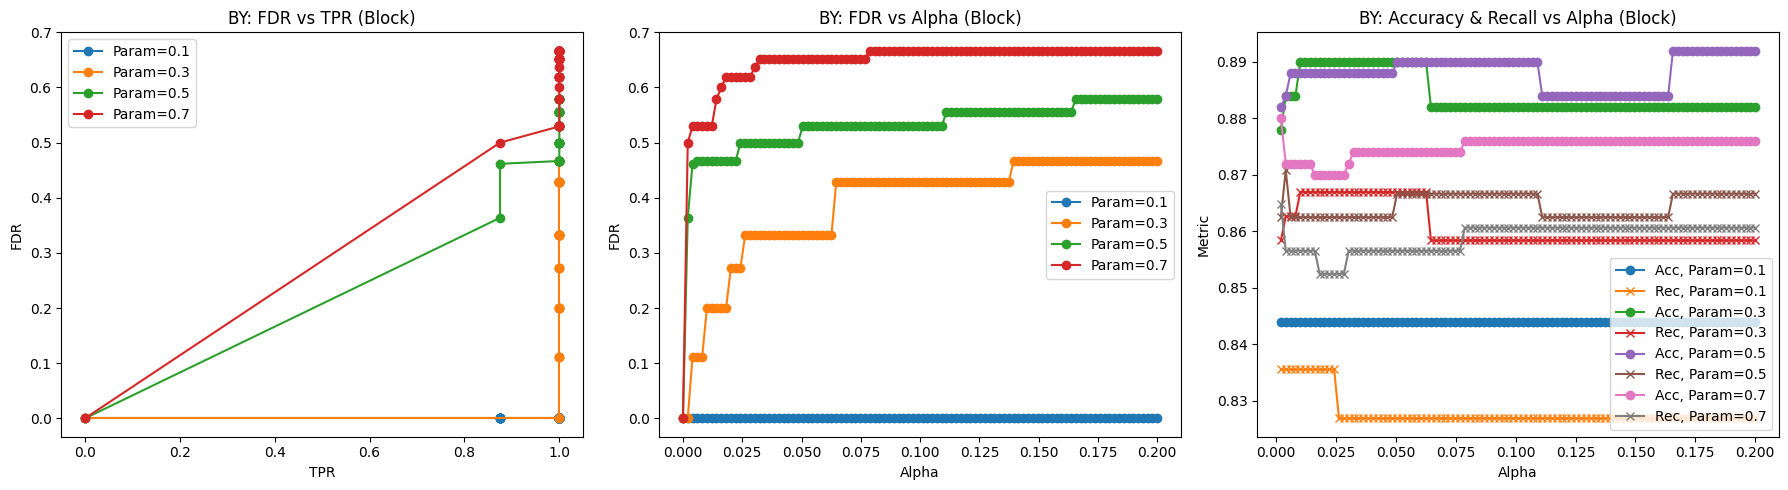

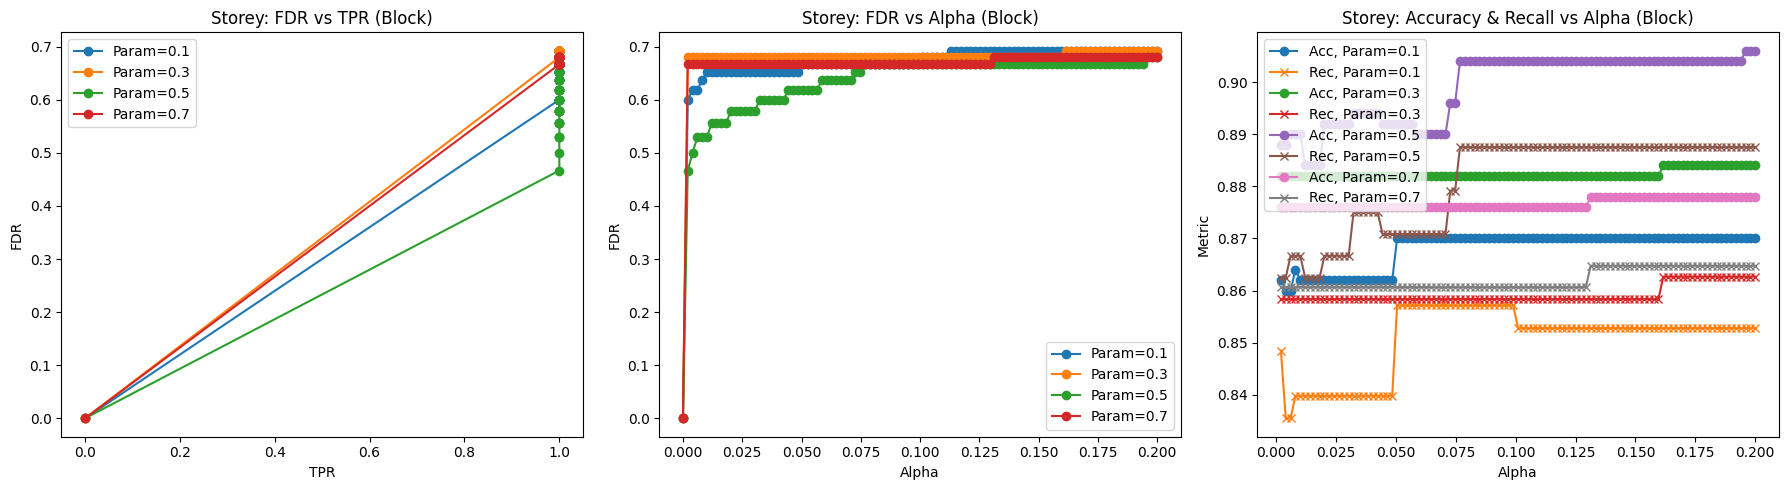

In [18]:
alpha_list = np.linspace(0.00, 0.2, 100)

print("Running extended simulation for AR(1) structure...")
results_AR1 = run_extended_simulation(correlation_type='AR1', corr_params=[0, 0.3, 0.6, 0.8],
                                      n_samples=500, n_features=32, n_true=8, alpha_list=alpha_list)

print("Running extended simulation for CS structure...")
results_CS = run_extended_simulation(correlation_type='CS', corr_params=[0.1, 0.3, 0.5, 0.7],
                                     n_samples=500, n_features=32, n_true=8, alpha_list=alpha_list)

print("Running extended simulation for Block structure...")
results_Block = run_extended_simulation(correlation_type='Block', corr_params=[0.1, 0.3, 0.5, 0.7],
                                        n_samples=500, n_features=32, n_true=8, alpha_list=alpha_list)
